In [1]:
#!pip3 install lightning torchsummary --user
#!pip3 install scikit-learn --user 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "?"
import sys
import numpy as np
import torch 
import lightning as lightning
import matplotlib.pyplot as plt
from networks import *
from torchsummary import summary
from utils_multiDim import *
import random
import tqdm
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
%load_ext autoreload 
%autoreload 2

In [9]:
#initialize datasets
batchsize=6
#path_sparse = '/data-pool/data_no_backup/ga63cun/PE/64'
#path_gt = '/data-pool/data_no_backup/ga63cun/PE/4095'
path_sparse = '/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted_sparse/cone/128_angles'
path_gt = '/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted'
save_path = "./model_weights/2DUNet/"       

residual=False
if residual:
    save_path = "./model_weights/2DUNet-res/"

#df_train = pd.read_csv("./Test_allImages.csv")
#df_val = pd.read_csv("./Test_allImages.csv")
df_train = pd.read_csv("./train.csv") #I just put in the test csv path here
df_val = pd.read_csv("./val.csv") #I just put in the test csv path here

#initialize training parameters
lr = 1e-5
weight_decay = 1e-2 
optimizer_algo = "AdamW" 
optimizer_params={"weight_decay": weight_decay}
scheduler_algo = "StepLR"
scheduler_params = {"step_size":4, "gamma":0.9}
#patch_size = (256, 256) 
block_size=(1, 128, 128)#(1, 512, 512)
ww = 3_000
wl = 0

In [10]:
dataset_train = SparseDataset(df = df_train, 
                 dim = '2d',
                 residual = residual,
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = False, 
                 data_size = block_size,#patch_size, 
                 ww=ww, 
                 wl=wl
                             )

dataset_val = SparseDataset(df = df_val, 
                 dim = '2d',
                 residual = residual,
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = False, 
                 data_size = block_size, #patch_size, 
                 ww=ww, 
                 wl=wl
                           )

dataloader_train = DataLoader(dataset_train, batch_size=batchsize, num_workers=4, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, num_workers=4, shuffle=False)

In [11]:
#test dataloader

batch_sparse_train, batch_gt_train = next(iter(dataloader_train))#[i for i in tqdm.tqdm(iter(dataloader_train))]
batch_sparse_val, batch_gt_val = next(iter(dataloader_val))

In [12]:
batch_sparse_train.shape, batch_sparse_train[0].min()

(torch.Size([6, 1, 128, 128]), tensor(-0.5203, dtype=torch.float64))

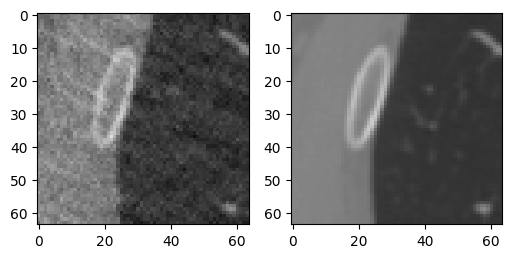

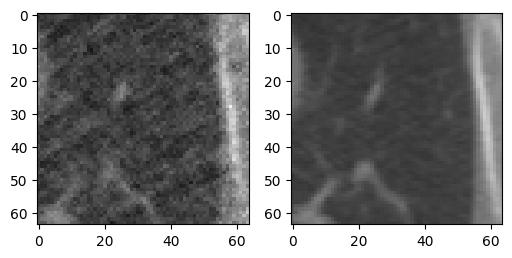

In [11]:
n = 1#batch number

k=np.s_[n,0,:,:] #2d

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#print(batch_label_train[k])
ax[0].imshow(batch_sparse_train[k], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_train[k], cmap='gray', vmin=0, vmax=1)


fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#print(batch_label_val[k])
ax[0].imshow(batch_sparse_val[k], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_val[k], cmap='gray', vmin=0, vmax=1)




In [14]:
#initialize model
unet = UNet(n_channels=1, n_classes=1, bilinear=False).float()

In [15]:
model = LitModel(unet=unet, 
                 optimizer_algo=optimizer_algo, 
                 optimizer_params=optimizer_params,
                 loss = nn.MSELoss(reduction='mean'), 
                 lr = lr,
                 scheduler_algo="StepLR",
                 scheduler_params=scheduler_params
                   )

lr_monitor = lightning.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch')
tblogger = TensorBoardLogger(save_path)
csvlogger = CSVLogger(save_path, version=tblogger.version)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=7)

trainer = L.Trainer(logger=[csvlogger, tblogger], #tblogger
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, dataloader_train, dataloader_val)

You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-09-22 19:17:42.022234: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 19:17:42.066867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 19:17:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
# find learning rate
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, dataloader_train, min_lr=1e-7, max_lr=9e-1, num_training=150, early_stop_threshold=50)
print(lr_finder.suggestion())
plt.plot(lr_finder.results["lr"], lr_finder.results["loss"])
plt.xscale("log")

/home/ge37wup/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Finding best initial lr:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
Learning rate set to 5.4367002251314176e-05
Restoring states from the checkpoint path at /users/Dorosti/3DCNN_ArtifactReduction/.lr_find_dd952653-2797-40e2-ac95-73672ee77814.ckpt
Restored all states from the checkpoint at /users/Dorosti/3DCNN_ArtifactReduction/.lr_find_dd952653-2797-40e2-ac95-73672ee77814.ckpt
/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

1.3571703702625477e-05


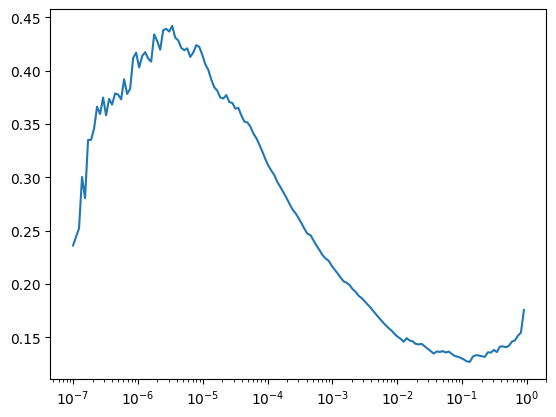

In [18]:
print(lr_finder.suggestion())
plt.plot(lr_finder.results["lr"], lr_finder.results["loss"])
plt.xscale("log")

In [8]:
#test if model overfits on 2 batches
trainer = lightning.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400, overfit_batches=2)

trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.8/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:572: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | unet | UNet    | 17.3 M | train
1 | loss | MSELoss | 0      | train
-----------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.047 

ValueError: 
 you tried to log -1 which is currently not supported. Try a dict or a scalar/tensor.

In [ ]:
#load model from checkpoint
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()
# to retrieve the model call on the checkpoint:
model = LitModel.load_from_checkpoint("./model_weights/2DUNet/lightning_logs/version_28/checkpoints/epoch=6-step=2303.ckpt", unet=unet)
# to predict just provide the lit model with the input batch
model.eval()
inpt_batch = batch_sparse_val
pred = model.forward(x=inpt_batch.float().cuda())

In [6]:
inpt_batch.shape

torch.Size([16, 1, 128, 128])

In [7]:
np.shape(pred)

torch.Size([16, 1, 128, 128])

(-0.5, 127.5, 127.5, -0.5)

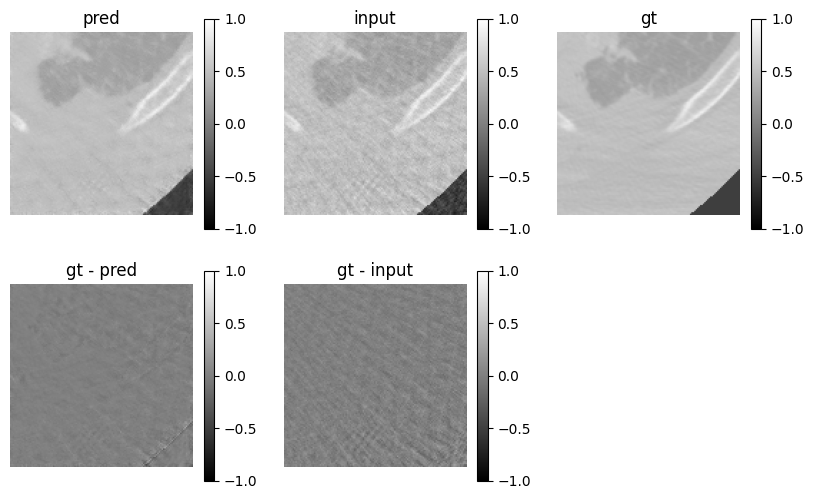

In [8]:
plt.figure(figsize=(10,6))
k=1
plt.subplot(231)
plt.imshow(pred[k,0,:,:].cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.title('pred')
plt.axis('off')
plt.subplot(232)
plt.imshow(inpt_batch[k,0,:,:], cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.title('input')
plt.axis('off')
plt.subplot(233)
plt.imshow(batch_gt_val[k,0,:,:], cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.title('gt')
plt.axis('off')

plt.subplot(234)
plt.imshow(batch_gt_val[k,0,:,:] - pred[k,0,:,:].cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.title('gt - pred')
plt.axis('off')
plt.subplot(235)
plt.imshow(batch_gt_val[k,0,:,:] - inpt_batch[k,0,:,:], cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.title('gt - input')
plt.axis('off')

